In [42]:
from surveysim.area import Area
import geopandas as gpd
%matplotlib inline
import numpy as np

In [31]:
area = Area.from_shapefile(name='SonServera', path='../data/area_test/Survey_Fields_Master.shp')

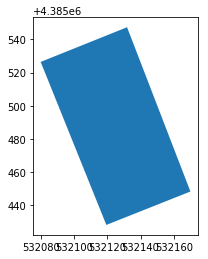

In [32]:
area.data.plot()

In [105]:
spacing = 20
sweep_width = 5
angle = 50
sec_per_unit_dist = 1

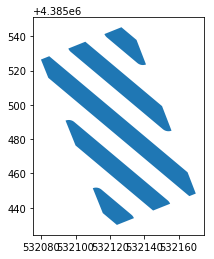

In [106]:
from math import sqrt
from shapely.geometry import LineString, Point
# find longest dimension (longest diagonal of bbox)
bounds = area.data.bounds
width = bounds.maxx.max() - bounds.minx.min()
height = bounds.maxy.max() - bounds.miny.max()
diag_dist = sqrt(width**2 + height**2)

# calculate num of lines
n_transects = int(diag_dist // spacing)

# start at centroid of bounding box
centroid = area.data.boundary.centroid.iloc[0]

# fill out lines
# calculate x values
if n_transects % 2 == 0:  # even num transects
    left_start = centroid.x - spacing/2
    right_start = centroid.x + spacing/2
    left_xs = left_start - (np.arange(0, n_transects/2) * spacing)
    right_xs = right_start + (np.arange(0, n_transects/2) * spacing)
    xs = np.sort(np.concatenate([left_xs, right_xs]))
else:  # odd num transects
    start_x = centroid.x
    left_xs = start_x - (np.arange(1, n_transects/2) * spacing)
    right_xs = start_x + (np.arange(1, n_transects/2) * spacing)
    xs = np.sort(np.insert(np.concatenate([left_xs, right_xs]), 1, start_x))
    
y_max = centroid.y + diag_dist / 2
y_min = centroid.y - diag_dist / 2

top_coords = list(zip(xs, np.full_like(xs, fill_value=y_max)))
bottom_coords = list(zip(xs, np.full_like(xs, fill_value=y_min)))

lines_gs = gpd.GeoSeries([LineString(coord_pair) for coord_pair in zip(top_coords, bottom_coords)])
lines_gs = lines_gs.rotate(angle, origin = Point(centroid.x, centroid.y))
lines_gdf = gpd.GeoDataFrame({'geometry': lines_gs}, 
                             geometry='geometry')

# clip lines by area
poly = area.data.geometry.unary_union
spatial_index = lines_gdf.sindex
bbox = poly.bounds
sidx = list(spatial_index.intersection(bbox))
lines_sub = lines_gdf.iloc[sidx]
clipped = lines_sub.copy()
clipped['geometry'] = lines_sub.intersection(poly)
lines_clipped = clipped[clipped.geometry.notnull()]


transects_buffer = lines_clipped.buffer(sweep_width)  # buffer transects
buffer_gdf = gpd.GeoDataFrame({'angle_deg':[angle] * transects_buffer.shape[0],
                               'length': lines_clipped.length,
                               'geometry': transects_buffer}, 
                               geometry='geometry')

transects = gpd.overlay(buffer_gdf, area.data, how='intersection')
transects['area'] = transects.area
transects['min_search_time'] = sec_per_unit_dist * transects['length']
# add su_id column
transects['su_id'] = [i for i in range(transects.shape[0])]
transects = transects.loc[:, ['su_id', 'angle_deg', 'length', 'area_name', 'visibility', 'geometry', 'area', 'min_search_time']]

transects.plot()

In [66]:
centroid.x, spacing/2, left_xs, right_xs

(532125.1945589299,
 5.0,
 array([532120.19455893, 532110.19455893, 532100.19455893, 532090.19455893,
        532080.19455893, 532070.19455893, 532060.19455893]),
 array([532130.19455893, 532140.19455893, 532150.19455893, 532160.19455893,
        532170.19455893, 532180.19455893, 532190.19455893]))

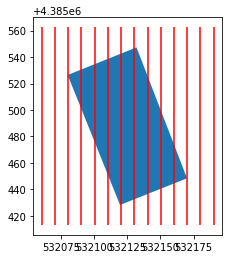

In [67]:
lines_gdf.plot(ax=area.data.plot(), color='red')

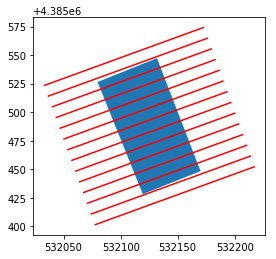

In [89]:
from shapely.geometry import Point
lines_gs.rotate(110, origin = Point(centroid.x, centroid.y)).plot(ax=area.data.plot(), color='red')

In [ ]:
def make_transects(transect_interval, sweep_width, angle_degrees, area_gdf, sec_per_unit_dist):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString

    xmin = area_gdf.bounds.minx.min()
    xmax = area_gdf.bounds.maxx.max()
    ymin = area_gdf.bounds.miny.min()
    ymax = area_gdf.bounds.maxy.max()

    h = ymax-ymin

    def standard(temp_angle):
        theta = np.radians(temp_angle)
        horiz_shift = (1/np.cos(theta)) * transect_interval
        top_start = xmin
        
        # calculate bottom starting point
        a = (1/np.tan(theta)) * transect_interval
        b = h - a
        bottom_start_shift = np.tan(theta) * b
        bottom_start = xmin - bottom_start_shift
        
        n_transects = int((xmax - bottom_start) / horiz_shift)
        
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects
    
    def special(horiz_shift, top_start, bottom_start):
        n_transects = int((xmax - bottom_start) / horiz_shift)
    
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects


    if 0 < angle_degrees < 90:
        top_vals, bottom_vals, n_transects = standard(angle_degrees)
        
    elif 90 < angle_degrees < 180:
        supplement = 180 - angle_degrees
        bottom_vals, top_vals, n_transects = standard(supplement)
        
    elif angle_degrees in [0, 180]:
        horiz_shift = transect_interval
        top_start = xmin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    elif angle_degrees == 90:
        horiz_shift = transect_interval
        top_start = ymin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    top_coords = list(zip(top_vals, np.full_like(top_vals, fill_value=ymax)))
    bottom_coords = list(zip(bottom_vals, np.full_like(bottom_vals, fill_value=ymin)))

    lines_gs = gpd.GeoSeries([LineString(coord_pair) for coord_pair in zip(top_coords, bottom_coords)])
    lines_gdf = gpd.GeoDataFrame({'length': np.arange(0, n_transects),
                                  'geometry': lines_gs
                                 }, geometry='geometry')
    
    # clip lines by bounding box
    poly = area1.geometry.unary_union
    spatial_index = lines_gdf.sindex
    bbox = poly.bounds
    sidx = list(spatial_index.intersection(bbox))
    lines_sub = lines_gdf.iloc[sidx]
    clipped = lines_sub.copy()
    clipped['geometry'] = lines_sub.intersection(poly)
    lines_clipped = clipped[clipped.geometry.notnull()]
    
    
    transects_buffer = lines_clipped.buffer(sweep_width)  # buffer transects
    buffer_gdf = gpd.GeoDataFrame({'angle_deg':[angle_degrees] * n_transects,
                                   'length': lines_clipped.length,
                                   'geometry': transects_buffer}, 
                                   geometry='geometry')

    transects = gpd.overlay(buffer_gdf, area_gdf, how='intersection')
    transects['area'] = transects.area
    transects['min_search_time'] = sec_per_unit_dist * transects['length']
    # add su_id column
    transects['su_id'] = [i for i in range(transects.shape[0])]
    transects = transects.loc[:, ['su_id', 'angle_deg', 'length', 'area_name', 'visibility', 'geometry', 'area', 'min_search_time']]
    
    return transects